# Proyectos de Kickstarter

Para esta semana, deberá utilizar los datos de (proyectos.csv aprox 58Mb) donde encontrará 378 mil proyectos de Kickstarter. No todos los proyectos son exitosos. Ud deberá construir un modelo con Naibe Bayes Gaussiano y KNN para predecir el estado del proyecto.

## Datos:

- y: state (failed, canceled, succesful, live, suspended, etc..)

- X:
    - ID: identificador del proyecto
    - name: nombre del proyecto
    - category: sub-categoria del proyecto
    - main_category: categoria del proyecto
    - currency: moneda de la peticion.
    - deadline: fecha de vencimiento del proyecto
    - goal: dinero a obtener en el proyecto
    - launched: fecha de inicio del proyecto
    - pledged: dinero solicitado por la comunidad
    - backers: cantidad de donantes de dinero
    - country: pais de origen del proyecto
    - usd_pledged: conversion en dolares de la columna pledged
    - usd_pledged_real: conversion en dolares de la columna pledged por Fixer.io API
    - usd_goal_real: conversion en dolares de la columna goal por Fixer.io API
    
### Problema Semanal:

Ud tiene duda de cual modelo de machine learning funciona mejor para este problema, si KNN o Naive Bayes Gaussiano. Para esto ud deberá realizar el analsis necesario de escogencia de modelos para determina cual es el mejor modelo.

### Algunas recomendaciones:

- considere no utilizar proyectos que estan con estado "Live".
- puede crear o eliminar columnas segun lo considere necesario.
- utilize transformaciones, scaling, normalizacion y feature engineering para "tunear" su modelo.
- utilize la matrix de confusion y las metricas de F1Score, etc para comparar los modelos.
- Puede utilizar test-train split. Considere un test set del (+-)30%.
- utilize diversions hiperparametros para encontrar el mejor fit a su problema.
- utilize el chat de WhatsApp para apoyar a sus companeros y hacer preguntas.
- Si ud inicia este proyecto el viernes en la manana, probablemente no va a poder terminar. Do it on time. 
- haga drop de la columna name, ya que no hemos visto nada de NLP.

### Descargar Datos:
Los datos para este proyecto estan en el aula virtual en semana 6.

In [1]:
# ANTORCHA!
# feature engineering (transformacion, norm, eliminar var, etc...): 5 pts
# entrenamiento de modelos: 5pts
# model selection: uso de metricas para comprar modelos y matrices de confusion: 5 pts
# considere crear un resumen al final donde se puedan comparar las metricas "taco-a-taco" 
# para que quede bien explicado cual modelo es el mejor.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler

In [3]:
def show_plot(k_values,accuracy_values):
    fig = plt.figure()
    fig.subplots_adjust(top=0.8)
    ax1 = fig.add_subplot()
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('K value')
    plt.plot(k_values,accuracy_values,label='Accuracy for k params')
    plt.scatter(k_values,accuracy_values,c=k_values,alpha=1)
    plt.legend()
    plt.show()

In [4]:
def show_knn_model(k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    accuracy_values.append(acc)
    KNN_accuracy = acc
    sc=cross_val_score(model, X_test, y_test, cv=5).mean()
    KNN_score = sc
    print('---------------------------------------------------------')   
    print('Accuracy for k={}:'.format(str(k)),acc)
    print('\n')
    print('=========================================================')
    print("\n")
    print('Score:', sc)
    print('\n')
    print('=========================================================')
    print("\n")
    print(classification_report(y_test, predictions,zero_division=0))
    print('=========================================================')
    print('\n')
    return KNN_accuracy,sc
    

In [5]:
# Loading data
data = pd.read_csv('data/proyectos.csv')
columns_to_drop = ['name','deadline','launched','ID']
data = data.drop(columns_to_drop,axis='columns')
data.head()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,1000.0,0.0,failed,0,GB,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,30000.0,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,45000.0,220.0,failed,3,US,220.0,220.0,45000.00
3,Music,Music,USD,5000.0,1.0,failed,1,US,1.0,1.0,5000.00
4,Film & Video,Film & Video,USD,19500.0,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Dado que tenemos variables categoricas haremos una transformación de estas variables. Para esto usaré LabelEncoder.

In [6]:
le = preprocessing.LabelEncoder()
data.category = le.fit(data.category).transform(data.category)
data.main_category = le.fit(data.main_category).transform(data.main_category)
data.currency = le.fit(data.currency).transform(data.currency)
data.country = le.fit(data.country).transform(data.country)
data.state = le.fit(data.state).transform(data.state)
#Mostramos el estado del dataset una vez transformado
data.head()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,108,12,5,1000.0,0.0,1,0,9,0.0,0.0,1533.95
1,93,6,13,30000.0,2421.0,1,15,22,100.0,2421.0,30000.00
2,93,6,13,45000.0,220.0,1,3,22,220.0,220.0,45000.00
3,90,10,13,5000.0,1.0,1,1,22,1.0,1.0,5000.00
4,55,6,13,19500.0,1283.0,0,14,22,1283.0,1283.0,19500.00


Empezaremos por mostrar la matriz de correlaciones

In [7]:
corr = data.corr()
corr.style.background_gradient(cmap='plasma').set_precision(2)

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
category,1.00,0.20,-0.01,0.00,0.03,0.01,0.04,-0.01,0.03,0.03,0.00
main_category,0.20,1.00,-0.01,0.00,0.00,-0.01,0.00,-0.01,0.01,0.01,0.00
currency,-0.01,-0.01,1.00,-0.01,0.01,0.06,0.01,0.98,0.01,0.01,-0.00
goal,0.00,0.00,-0.01,1.00,0.01,-0.02,0.00,-0.00,0.01,0.01,0.94
pledged,0.03,0.00,0.01,0.01,1.00,0.10,0.72,0.01,0.86,0.95,0.01
state,0.01,-0.01,0.06,-0.02,0.10,1.00,0.11,0.05,0.09,0.10,-0.02
backers,0.04,0.00,0.01,0.00,0.72,0.11,1.00,0.01,0.70,0.75,0.00
country,-0.01,-0.01,0.98,-0.00,0.01,0.05,0.01,1.00,0.01,0.01,-0.00
usd pledged,0.03,0.01,0.01,0.01,0.86,0.09,0.70,0.01,1.00,0.91,0.01
usd_pledged_real,0.03,0.01,0.01,0.01,0.95,0.10,0.75,0.01,0.91,1.00,0.01


Primero removeremos los proyecto cuyo estado sea live y luego tomamos state como la variable 'y' y luego las demás variables como la variable X

In [8]:
data = data[data['state']!='live']
y = data['state']
X = data.drop(['state'],axis=1)

/Users/oscar/ml-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [9]:
goal = X['goal'].values.reshape(1,-1)
goal_scaled = RobustScaler().fit(goal).transform(goal)
X['goal'] = goal_scaled.reshape(-1,1)

In [10]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X)
X = imp_mean.transform(X)

In [11]:
print('X shape:',X.shape)
print('y shape:',y.shape)

X shape: (378661, 10)
y shape: (378661,)


In [12]:
X

array([[1.08000e+02, 1.20000e+01, 5.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.53395e+03],
       [9.30000e+01, 6.00000e+00, 1.30000e+01, ..., 1.00000e+02,
        2.42100e+03, 3.00000e+04],
       [9.30000e+01, 6.00000e+00, 1.30000e+01, ..., 2.20000e+02,
        2.20000e+02, 4.50000e+04],
       ...,
       [9.30000e+01, 6.00000e+00, 1.30000e+01, ..., 2.00000e+01,
        2.00000e+01, 1.50000e+04],
       [1.38000e+02, 1.30000e+01, 1.30000e+01, ..., 2.00000e+02,
        2.00000e+02, 1.50000e+04],
       [9.80000e+01, 0.00000e+00, 1.30000e+01, ..., 5.24000e+02,
        5.24000e+02, 2.00000e+03]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [14]:
NB_model = GaussianNB()
predictions = NB_model.fit(X_train, y_train).predict(X_test)
NB_accuracy = accuracy_score(y_test, predictions)
cross_val_score_NB = cross_val_score(NB_model, X_test, y_test, cv=5).mean()
print("Accuracy:",accuracy_score(y_test, predictions))
print("\n")
print("=========================================")
print("\n")
print(classification_report(y_test, predictions))

Accuracy: 0.5820297713888326




              precision    recall  f1-score   support

           0       0.05      0.03      0.04     11764
           1       0.59      0.98      0.73     59162
           2       0.00      0.00      0.00       844
           3       0.93      0.17      0.29     40203
           4       0.00      0.00      0.00       562
           5       0.77      1.00      0.87      1064

    accuracy                           0.58    113599
   macro avg       0.39      0.36      0.32    113599
weighted avg       0.65      0.58      0.50    113599



---------------------------------------------------------
Accuracy for k=1: 0.8111779152985502




Score: 0.8092060389207024




              precision    recall  f1-score   support

           0       0.18      0.17      0.18     11764
           1       0.83      0.83      0.83     59162
           2       0.05      0.04      0.04       844
           3       0.99      0.99      0.99     40203
           4       0.02      0.02      0.02       562
           5       0.92      0.92      0.92      1064

    accuracy                           0.81    113599
   macro avg       0.50      0.50      0.50    113599
weighted avg       0.81      0.81      0.81    113599



---------------------------------------------------------
Accuracy for k=3: 0.8492680393313321




Score: 0.8478771669366522




              precision    recall  f1-score   support

           0       0.19      0.10      0.13     11764
           1       0.83      0.92      0.87     59162
           2       0.09      0.01 

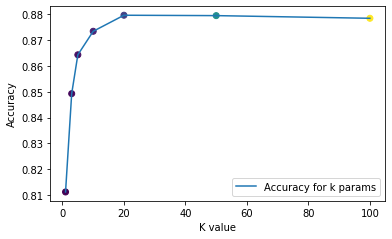

In [15]:
k_values = [1, 3, 5, 10, 20, 50, 100]
accuracy_values = []
for k in k_values:
    show_knn_model(k)
show_plot(k_values,accuracy_values)

A pesar de aplicar algunos escalamientos y transformaciones el mode de Bayes se comportó siempre por debajo del modelo de KNN

In [16]:
KNN_accuracy,KNN_score= show_knn_model(20)

---------------------------------------------------------
Accuracy for k=20: 0.879646827877006




Score: 0.8782207546081985




              precision    recall  f1-score   support

           0       0.22      0.00      0.01     11764
           1       0.82      0.99      0.90     59162
           2       0.00      0.00      0.00       844
           3       0.98      1.00      0.99     40203
           4       0.00      0.00      0.00       562
           5       0.93      0.93      0.93      1064

    accuracy                           0.88    113599
   macro avg       0.49      0.49      0.47    113599
weighted avg       0.81      0.88      0.83    113599





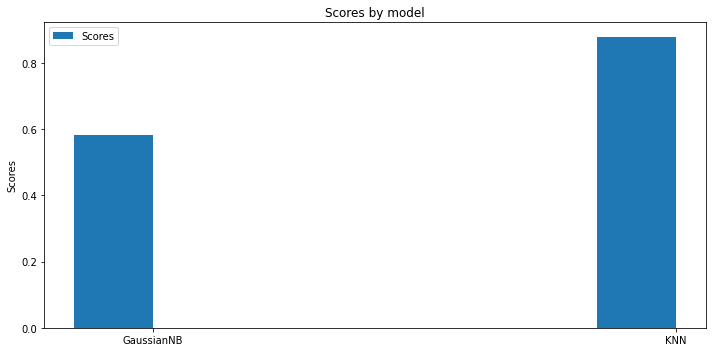

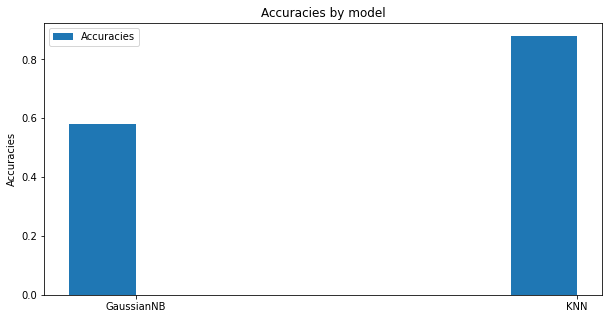

In [17]:
accuracies= [NB_accuracy,KNN_accuracy]
scores = [cross_val_score_NB,KNN_score]
labels = ['GaussianNB', 'KNN']
width_height_1 = (10, 5)

x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=width_height_1)
rects1 = ax.bar(x - width/2, scores, width, label='Scores')

ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=width_height_1)
rects2 = ax2.bar(x - width/2, accuracies, width, label='Accuracies')
ax2.set_ylabel('Accuracies')
ax2.set_title('Accuracies by model')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.show()